In [14]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import json
import numpy as np
from matplotlib import pyplot as plt

from lib.BBData import character_dict
from lib.BBDataLoad import open_char_dataset, process_char_dataset
from lib.metrics.persgraph_classifier import TVShowGraphDataset, PersGRAPH_classifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# load the pretrained model if True
F_pretrained = False
# flag for crete data
F_create_data = False
# load characters names
characters = list(character_dict.keys())
# setup folders
base_folder = os.getcwd()
data_folder = join(base_folder, 'Data')
pt_folder = join(base_folder, 'Data', 'pt_graphs')
characters_folder = join(data_folder, 'Characters')
model_folder = join(os.getcwd(), 'models', 'persgraph_classifier')
model_path = join(model_folder, 'persgraph_classifier')

# PersGRAPH classifier

This model implement another approach to look at this task considering the sentence embedding

<img src="../images/PersGRAPH_classifier.jpg" alt="PersGRAPH classifier" />

In [16]:
# initialize model
persgraph_cls = PersGRAPH_classifier(model_path, from_pretrained=F_pretrained, use_cuda=True)
if F_create_data:
    # create data
    persgraph_cls.create_data(data_folder, characters_folder, 
                            verbose=True, override_graphs = True,
                            n_sentences_range=(20,30))

In [17]:
# setup vector to count how many graph in training set
count_data = [0 for c in characters]
folderset_path = join(data_folder, 'graphs', 'trainSet')
# count number of classes in json folder 
for jsonfile in os.listdir(folderset_path):
    graph = join(folderset_path, jsonfile)
    # read the file
    with open(graph, "r") as file:
        graphConversation = json.load(file)
        # extract label onehot vector
        yonehot = graphConversation['y']
        # count
        count_data[np.argmax(yonehot)] += 1
for c, ngraphs in zip(characters, count_data):
    print(f'num graphs for {c} is {ngraphs}')

num graphs for Barney is 3280
num graphs for Sheldon is 7391
num graphs for Harry is 630
num graphs for Fry is 1701
num graphs for Bender is 1492
num graphs for Vader is 72
num graphs for Joey is 5215
num graphs for Phoebe is 4735
num graphs for Default is 9371


---

In [18]:
X_train, X_valid, X_test = persgraph_cls.get_data(pt_folder, batch_size=512)

In [19]:
# train the model if not loaded a pretrained version of it
if not F_pretrained:
    train_histories = persgraph_cls.train(X_train, X_valid, epochs=50, optimizer='adamw', lr=2e-4, patience=15)
# read histories of trained model
history_path = join(model_folder, 'train_history.json')
with open(history_path, "r") as file:
    train_histories = json.load(file)

## Valid epoch = 31: 100%|██████████| 12/12 [00:01<00:00,  8.66it/s, valid_loss=0.457, valid_f1score=0.846]


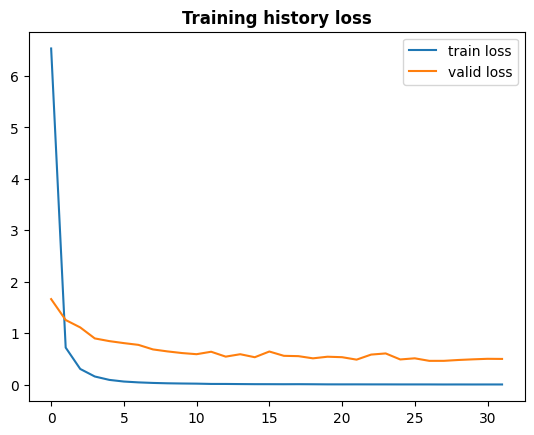

In [20]:
# plot training loss
plt.plot(train_histories['training_loss'])
plt.plot(train_histories['validation_loss'])
plt.legend(['train loss', 'valid loss'])
plt.title('Training history loss', fontweight='bold')
plt.show()

## Test : 100%|██████████| 26/26 [00:03<00:00,  7.25it/s]


0.6963825815256395


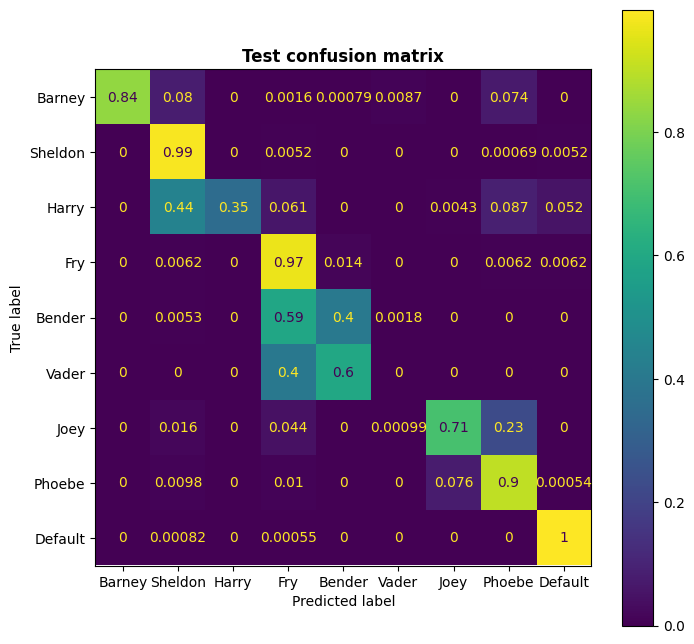

In [21]:
# plot test confusion metrix
persgraph_cls.test(X_test, normalize_cm=True);